In [2]:
import warnings
warnings.simplefilter(action='ignore')

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

from sklearn.preprocessing import StandardScaler as scaler

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, f1_score

# from sklearn import cross_validation

from sklearn.metrics import classification_report

from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay


from imblearn.over_sampling import SMOTE

rand_state = 481516


from sklearn.model_selection  import GridSearchCV

import xgboost as xgb

import matplotlib.pyplot as plt

Другой датасет

In [2]:
df = pd.read_csv('data_cat_to_int2.csv', index_col=0)
# df.iloc[488,19] = '0'
data = df.drop(columns = ['Churn'])
target = df['Churn']

In [3]:
def modelfit(alg, X_train, y_train, X_test, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
        xgtest = xgb.DMatrix(X_test.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    print(f'n_estimators = {cvresult.shape[0]}')
    alg.fit(X_train, y_train,eval_metric='aucpr')
        
    #Predict training set:
    X_train_predictions = alg.predict(X_train)
    X_train_predprob = alg.predict_proba(X_train)[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % accuracy_score(y_train, X_train_predictions))
    print ("AUC Score (Train): %f" % roc_auc_score(y_train, X_train_predprob))
    print ("balanced_accuracy_score : %.4g" % balanced_accuracy_score(y_train, X_train_predictions))
    print ("f1_score: %f" % f1_score(y_train, X_train_predictions))
    
    return  cvresult.shape[0]
#     Predict on testing data:
#     dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
#     results = test_results.merge(dtest[['ID','predprob']], on='ID')
#     print ('AUC Score (Test): %f' % metrics.roc_auc_score(results['Disbursed'], results['predprob']))
                
#     feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=rand_state)

Значения по умолчанию

In [5]:
xg_reg = xgb.XGBClassifier(use_label_encoder=False, verbosity = 0, silent=True,        
        objective= 'binary:logistic',
        eval_metric='auc',
        seed=27,
)


clf =  xg_reg

clf.fit(X_train, y_train)


X_train_pred = clf.predict(X_train)

print('Train:')
acc, b_acc = accuracy_score(X_train_pred, y_train), balanced_accuracy_score(X_train_pred, y_train)
print (f"acc = {acc}, bal_acc = {b_acc}")
print(classification_report(X_train_pred, y_train))


y_pred = clf.predict(X_test)

print('Test:')
acc, b_acc = accuracy_score(y_test, y_pred), balanced_accuracy_score(y_test, y_pred)
print (f"acc = {acc}, bal_acc = {b_acc}")
print(classification_report(y_test, y_pred))

all_pred = clf.predict(data)

print('All:')
acc, b_acc = accuracy_score(target, all_pred), balanced_accuracy_score(target, all_pred)
print (f"acc = {acc}, bal_acc = {b_acc}")
print(classification_report(target, all_pred))

Train:
acc = 0.9263400780972666, bal_acc = 0.9121970074610837
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      4236
           1       0.83      0.88      0.86      1398

    accuracy                           0.93      5634
   macro avg       0.90      0.91      0.90      5634
weighted avg       0.93      0.93      0.93      5634

Test:
acc = 0.7856635911994322, bal_acc = 0.7071965628356606
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1029
           1       0.62      0.54      0.57       380

    accuracy                           0.79      1409
   macro avg       0.73      0.71      0.72      1409
weighted avg       0.78      0.79      0.78      1409

All:
acc = 0.8981967911401392, bal_acc = 0.857401279765912
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      5174
           1       0.83      0.77      0.80      1869



In [8]:
xgb1 = xgb.XGBClassifier(use_label_encoder=False,
        n_estimators=1000,        
        objective= 'binary:logistic',
        eval_metric='auc',
        seed=27,
        )

n_est = modelfit(xgb1, X_train, y_train, X_test, y_test)

n_estimators = 11

Model Report
Accuracy : 0.834
AUC Score (Train): 0.900873
balanced_accuracy_score : 0.7527
f1_score: 0.648892


In [9]:
n_est

11

In [10]:
param_test1 = {
    'max_depth':range(3,11,1),
    'min_child_weight':range(1,11,2)
}

estimator = xgb.XGBClassifier(use_label_encoder=False, verbosity = 0, silent=True,                
        objective= 'binary:logistic',
        eval_metric='auc',        
        seed=27,
        n_estimators = n_est,
                              
)


gsearch1 = GridSearchCV(estimator = estimator, 
                        param_grid = param_test1, 
                        scoring='balanced_accuracy', cv=5)

gsearch1.fit(X_train, y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 4, 'min_child_weight': 1}, 0.7108384492861626)

In [11]:
md = 4
mcw = 1

In [13]:
param_test2 = {
    'scale_pos_weight':range(1,15),
}


estimator = xgb.XGBClassifier(use_label_encoder=False, verbosity = 0, silent=True,
                              objective= 'binary:logistic',
        eval_metric='auc',        
        seed=27,
        n_estimators = n_est,                              
        max_depth = md,
        min_child_weight = mcw,
)


gsearch2 = GridSearchCV(estimator = estimator, 
                       param_grid = param_test2, 
                        scoring='balanced_accuracy', cv=5)
gsearch2.fit(X_train, y_train)
gsearch2.best_params_, gsearch2.best_score_

({'scale_pos_weight': 3}, 0.7621761776245629)

In [14]:
spw = 3

In [18]:
param_test3 = {
    'gamma':range(0,20)
}

estimator = xgb.XGBClassifier(use_label_encoder=False, verbosity = 0, silent=True,
                              objective= 'binary:logistic',
        eval_metric='auc',        
        seed=27,
        n_estimators = n_est,                              
        max_depth = md,
        min_child_weight = mcw,
        scale_pos_weight=spw,
        )


gsearch3 = GridSearchCV(estimator = estimator, 
                       param_grid = param_test3, 
                        scoring='balanced_accuracy', cv=5)
gsearch3.fit(X_train, y_train)
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 5}, 0.7675047416929364)

In [19]:
param_test3b = {
    'gamma':[i/10.0 for i in range(45,56)]
}

estimator = xgb.XGBClassifier(use_label_encoder=False, verbosity = 0, silent=True,
                              objective= 'binary:logistic',
        eval_metric='auc',        
        seed=27,
        n_estimators = n_est,                              
        max_depth = md,
        min_child_weight = mcw,
        scale_pos_weight=spw,
)


gsearch3b = GridSearchCV(estimator = estimator, 
                       param_grid = param_test3b, 
                        scoring='balanced_accuracy', cv=5)
gsearch3b.fit(X_train, y_train)
gsearch3b.best_params_, gsearch3b.best_score_

({'gamma': 5.0}, 0.7675047416929364)

In [17]:
gm = 5

In [21]:
param_test4 = {
    'subsample':[i/10.0 for i in range(4,11)],
    'colsample_bytree':[i/10.0 for i in range(4,11)]
}

estimator = xgb.XGBClassifier(use_label_encoder=False, verbosity = 0, silent=True,
                              objective= 'binary:logistic',
        eval_metric='auc',        
        seed=27,
        n_estimators = n_est,                              
        max_depth = md,
        min_child_weight = mcw,
        scale_pos_weight=spw,
        gamma = gm,
)


gsearch4 = GridSearchCV(estimator = estimator, 
                       param_grid = param_test4, 
                        scoring='balanced_accuracy', cv=5)
gsearch4.fit(X_train, y_train)
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 1.0, 'subsample': 1.0}, 0.7675047416929364)

In [22]:
cb = 1
sbs = 1

In [23]:
xgb2 = xgb.XGBClassifier(use_label_encoder=False, verbosity = 0, silent=True,
                              objective= 'binary:logistic',
        eval_metric='auc',        
        seed=27,
        n_estimators = 1000,                              
        max_depth = md,
        min_child_weight = mcw,
        scale_pos_weight=spw,
        gamma = gm,
        subsample = sbs,
        colsample_bytree = cb,
                        )

n_est2 = modelfit(xgb2, X_train, y_train, X_test, y_test)

n_estimators = 13

Model Report
Accuracy : 0.7638
AUC Score (Train): 0.871144
balanced_accuracy_score : 0.7919
f1_score: 0.655806


In [24]:
n_est2

13

In [27]:
param_test5 = {
    'reg_alpha':[0, 1e-6, 1e-5, 1e-2, 0.1, 1, 100]
}

estimator = xgb.XGBClassifier(use_label_encoder=False, verbosity = 0, silent=True,
                              objective= 'binary:logistic',
        eval_metric='auc',        
        seed=27,
        n_estimators = n_est,                              
        max_depth = md,
        min_child_weight = mcw,
        scale_pos_weight=spw,
        gamma = gm,
        subsample = sbs,
        colsample_bytree = cb,
)


gsearch5 = GridSearchCV(estimator = estimator, 
                       param_grid = param_test5, 
                        scoring='balanced_accuracy', cv=5)
gsearch5.fit(X_train, y_train)


gsearch5.best_params_, gsearch5.best_score_

({'reg_alpha': 0}, 0.7675047416929364)

In [30]:
ra = 0

In [30]:
param_test5b = {
    'reg_alpha':[0.15, 0.16, 0.17, 0.18, 0.19]
}

estimator = xgb.XGBClassifier(use_label_encoder=False, verbosity = 0, silent=True,
                              objective= 'binary:logistic',
        eval_metric='auc',        
        seed=27,
        n_estimators = n_est,                              
        max_depth = md,
        min_child_weight = mcw,
        scale_pos_weight=spw,
        gamma = gm,
        subsample = sbs,
        colsample_bytree = cb,
)


gsearch5b = GridSearchCV(estimator = estimator, 
                       param_grid = param_test5b, 
                        scoring='balanced_accuracy', cv=5)
gsearch5b.fit(X_train, y_train)


gsearch5b.best_params_, gsearch5b.best_score_

({'reg_alpha': 0.15}, 0.7690191435979602)

In [31]:
ra = 0.15

In [32]:
param_test6 = {
    'reg_lambda':[0, 1e-2, 0.1, 1, 2, 5, 10, 100]
}

estimator = xgb.XGBClassifier(use_label_encoder=False, verbosity = 0, silent=True,
                              objective= 'binary:logistic',
        eval_metric='auc',        
        seed=27,
        n_estimators = n_est,                              
        max_depth = md,
        min_child_weight = mcw,
        scale_pos_weight=spw,
        gamma = gm,
        subsample = sbs,
        colsample_bytree = cb,
        reg_alpha = ra,
)


gsearch6 = GridSearchCV(estimator = estimator, 
                        
                       param_grid = param_test6, 
                        scoring='balanced_accuracy', cv=5)
gsearch6.fit(X_train, y_train)


gsearch6.best_params_, gsearch6.best_score_

({'reg_lambda': 1}, 0.7690191435979602)

In [33]:
param_test6b = {
    'reg_lambda':[i/10 for i in range(5,21)]
}

estimator = xgb.XGBClassifier(use_label_encoder=False, verbosity = 0, silent=True,
                              objective= 'binary:logistic',
        eval_metric='auc',        
        seed=27,
        n_estimators = n_est,                              
        max_depth = md,
        min_child_weight = mcw,
        scale_pos_weight=spw,
        gamma = gm,
        subsample = sbs,
        colsample_bytree = cb,
        reg_alpha = ra,
)


gsearch6b = GridSearchCV(estimator = estimator, 
                        
                       param_grid = param_test6b, 
                        scoring='balanced_accuracy', cv=5)
gsearch6b.fit(X_train, y_train)


gsearch6b.best_params_, gsearch6b.best_score_

({'reg_lambda': 0.9}, 0.7692352166728994)

In [34]:
rl = 0.9

In [35]:
xgb3 = xgb.XGBClassifier(use_label_encoder=False, verbosity = 0, silent=True,
                              objective= 'binary:logistic',
        eval_metric='auc',        
        seed=27,
        n_estimators = 1000,                              
        max_depth = md,
        min_child_weight = mcw,
        scale_pos_weight=spw,
        gamma = gm,
        subsample = sbs,
        colsample_bytree = cb,
        reg_alpha = ra,
        reg_lambda = rl
                        )

n_est3 = modelfit(xgb3, X_train, y_train, X_test, y_test)

n_estimators = 13

Model Report
Accuracy : 0.7636
AUC Score (Train): 0.870900
balanced_accuracy_score : 0.7909
f1_score: 0.654922


In [36]:
xgb4 = xgb.XGBClassifier(se_label_encoder=False, verbosity = 0, silent=True,
                              objective= 'binary:logistic',
        eval_metric='aucpr',        
        seed=27,
        n_estimators = 1000,                              
        max_depth = md,
        min_child_weight = mcw,
        scale_pos_weight=spw,
        gamma = gm,
        subsample = sbs,
        colsample_bytree = cb,
        reg_alpha = ra,
        reg_lambda = rl,
        learning_rate =0.1,                )

n_est4 = modelfit(xgb4, X_train, y_train, X_test, y_test)

n_estimators = 53

Model Report
Accuracy : 0.7199
AUC Score (Train): 0.865792
balanced_accuracy_score : 0.7744
f1_score: 0.626774


In [36]:
xg_reg = xgb.XGBClassifier(use_label_encoder=False, verbosity = 0, silent=True,
                              objective= 'binary:logistic',
        eval_metric='auc',        
        seed=27,
        n_estimators = 13,                              
        max_depth = md,
        min_child_weight = mcw,
        scale_pos_weight=spw,
        gamma = gm,
        subsample = sbs,
        colsample_bytree = cb,
        reg_alpha = ra,
        reg_lambda = rl
)


clf =  xg_reg

clf.fit(X_train, y_train)


X_train_pred = clf.predict(X_train)

print('Train:')
acc, b_acc = accuracy_score(X_train_pred, y_train), balanced_accuracy_score(X_train_pred, y_train)
print (f"acc = {acc}, bal_acc = {b_acc}")
print(classification_report(X_train_pred, y_train))


y_pred = clf.predict(X_test)

print('Test:')
acc, b_acc = accuracy_score(y_test, y_pred), balanced_accuracy_score(y_test, y_pred)
print (f"acc = {acc}, bal_acc = {b_acc}")
print(classification_report(y_test, y_pred))

all_pred = clf.predict(data)

print('All:')
acc, b_acc = accuracy_score(target, all_pred), balanced_accuracy_score(target, all_pred)
print (f"acc = {acc}, bal_acc = {b_acc}")
print(classification_report(target, all_pred))

Train:
acc = 0.7635782747603834, bal_acc = 0.7320767218250251
              precision    recall  f1-score   support

           0       0.73      0.93      0.82      3263
           1       0.85      0.53      0.65      2371

    accuracy                           0.76      5634
   macro avg       0.79      0.73      0.74      5634
weighted avg       0.78      0.76      0.75      5634

Test:
acc = 0.7423704755145494, bal_acc = 0.7738223108792389
              precision    recall  f1-score   support

           0       0.92      0.71      0.80      1029
           1       0.51      0.84      0.64       380

    accuracy                           0.74      1409
   macro avg       0.72      0.77      0.72      1409
weighted avg       0.81      0.74      0.76      1409

All:
acc = 0.7593355104358938, bal_acc = 0.7874978051139758
              precision    recall  f1-score   support

           0       0.93      0.73      0.82      5174
           1       0.53      0.85      0.65      1869


<Figure size 640x480 with 0 Axes>

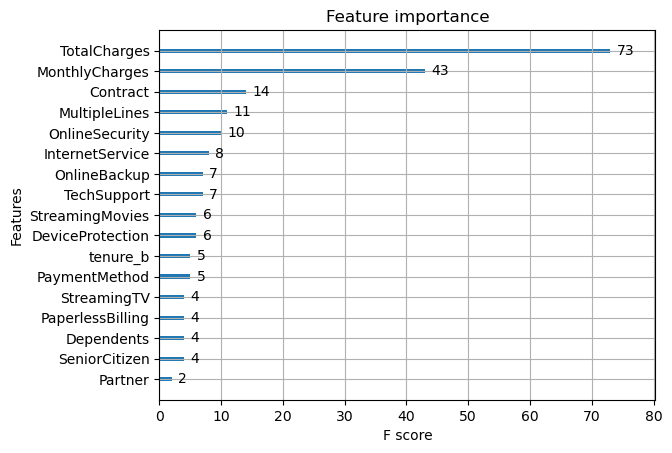

In [47]:
xgb.plot_importance(xg_reg, max_num_features = 20)
plt.show()
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

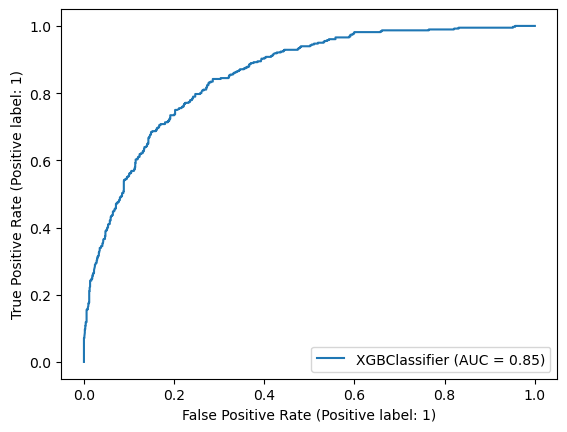

In [45]:
roc_curve = RocCurveDisplay.from_estimator(xg_reg, X_test, y_test)
plt.show()
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

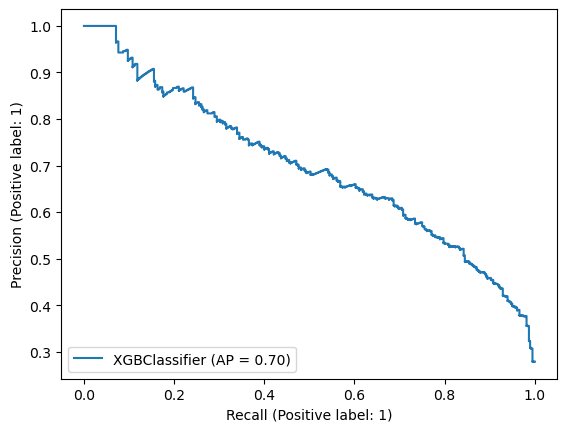

In [46]:
pr_curve = PrecisionRecallDisplay.from_estimator(xg_reg, X_test, y_test)
plt.show()
plt.tight_layout()